In [2]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier

In [8]:
base_dir = r"smart_aug/saved_augmented"
class_names = ['AD', 'CN', 'MCI']
total_images = 0

for class_name in class_names:
    path = os.path.join(base_dir, class_name)
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if f.lower().endswith('.jpg')])
        print(f"{class_name} axial images: {num_files}")
        total_images += num_files
    else:
        print(f" Path not found: {path}")

print("Total axial images:", total_images)


AD axial images: 32029
CN axial images: 32029
MCI axial images: 32029
Total axial images: 96087


In [4]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [28]:
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

Torch: 2.7.0
TorchVision: 0.22.0


In [ ]:
import torch
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from torchvision.models import densenet121, DenseNet121_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# ---- Model ----
weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

# ---- Transforms ----
class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()
])

augmenter = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    RepeatChannel(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ---- Paths and Labels ----
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

# ---- Mini-batch params ----
BATCH_SIZE = 64

for cls in classes:
    print(f"\nProcessing class: {cls}")
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    features, labels, image_paths = [], [], []
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.png')]

    for i in tqdm(range(0, len(file_list), BATCH_SIZE), desc=f"Class {cls}"):
        batch_filenames = file_list[i:i + BATCH_SIZE]
        orig_batch, aug_batch = [], []
        batch_paths, batch_labels = [], []

        for fname in batch_filenames:
            img_path = os.path.join(class_dir, fname)
            try:
                # Original
                monai_img = transform(img_path).unsqueeze(0)  # shape: [1, 3, 224, 224]
                orig_batch.append(monai_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path)

                # Augmented
                pil_img = Image.open(img_path).convert("L")
                aug_img = augmenter(pil_img).unsqueeze(0)
                aug_batch.append(aug_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

        # Stack and send to device
        if orig_batch:
            orig_batch_tensor = torch.cat(orig_batch).to(device)
            aug_batch_tensor = torch.cat(aug_batch).to(device)

            with torch.no_grad():
                orig_feats = feature_extractor(orig_batch_tensor).cpu().numpy()
                aug_feats = feature_extractor(aug_batch_tensor).cpu().numpy()

            all_feats = np.concatenate([orig_feats, aug_feats], axis=0)
            features.extend(all_feats)
            labels.extend(batch_labels)
            image_paths.extend(batch_paths)

    # Save after processing each class
    np.save(f"features_{cls}.npy", np.array(features))
    np.save(f"labels_{cls}.npy", np.array(labels))
    np.save(f"image_paths_{cls}.npy", np.array(image_paths))

    print(f"✅ Saved: features_{cls}.npy | labels_{cls}.npy | image_paths_{cls}.npy")

In [29]:
features_AD = np.load("features_AD.npy")
features_CN = np.load("features_CN.npy")
features_MCI = np.load("features_MCI.npy")

# Flatten: (35150, 1024, 7, 7) → (35150, 1024 * 7 * 7)
features_AD = features_AD.reshape(features_AD.shape[0], -1)
features_CN = features_CN.reshape(features_CN.shape[0], -1)
features_MCI = features_MCI.reshape(features_MCI.shape[0], -1)

In [ ]:
import numpy as np


# Labels
labels_AD = np.full(len(features_AD), 0)    # Alzheimer's Disease
labels_CN = np.full(len(features_CN), 1)    # Cognitively Normal
labels_MCI = np.full(len(features_MCI), 2)  # Mild Cognitive Impairment

features_AD = features_AD.astype(np.float16)
features_CN = features_CN.astype(np.float16)
features_MCI = features_MCI.astype(np.float16)

# Concatenate features and labels
all_features = np.concatenate([features_AD, features_CN, features_MCI], axis=0)
all_labels = np.concatenate([labels_AD, labels_CN, labels_MCI], axis=0)

print("All features shape:", all_features.shape)
print("All labels shape:", all_labels.shape)



In [4]:
# np.save("train_features_axial_monai.npy", all_features)
# np.save("train_labels_axial_monai.npy", all_labels)
all_features = np.load("train_features_axial_monai.npy")
print(all_features.shape)
print("Feature vectors saved:")
print("train_features_axial_monai.npy")
print("train_labels_axial_monai.npy")

(169650, 50176)
Feature vectors saved:
train_features_axial_monai.npy
train_labels_axial_monai.npy


same process as above for validation data

In [ ]:
import os
import numpy as np
from tqdm import tqdm
# import imgaug.augmenters as iaa
# from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from PIL import Image
from torchvision.models import densenet121, DenseNet121_Weights


# Extracting MONAI Image features

weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)

# Remove classifier (keep features before final dense layer)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

# --- MONAI Transform for original grayscale image ---
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),       # Shape: [1, H, W]
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()             # Now shape becomes [3, H, W]
])

# --- Torch augmentations for grayscale input ---
augmenter = T.Compose([
    T.Grayscale(num_output_channels=1),        # Enforce 1 channel
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),                               # -> [1, H, W]
    RepeatChannel(),                            # -> [3, H, W]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization
])

# EfficientNet base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)

# Step 4: Setup paths and label mapping
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/val"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

features, labels, image_paths = [], [], []

# Step 5: Loop through dataset and extract features

for cls in classes:
    print(cls)
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    for fname in tqdm(os.listdir(class_dir), desc=f"Processing {cls}"):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            try:
                # --------- Original Image (Grayscale assumed) ---------
                monai_img = transform(img_path).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]
                with torch.no_grad():
                    orig_feat = feature_extractor(monai_img).cpu().numpy().flatten()
                features.append(orig_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path)

                # --------- Augmented Image  ---------
                pil_img = Image.open(img_path).convert("L")
                aug_img_tensor = augmenter(pil_img).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]
                with torch.no_grad():
                    aug_feat = feature_extractor(aug_img_tensor).cpu().numpy().flatten()
                features.append(aug_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

# Step 6: Save features, labels, and paths
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("val_features_axial_monai.npy", features)
np.save("val_labels_axial_monai.npy", labels)
np.save("val_image_paths_axial_monai.npy", image_paths)

print("Feature vectors saved:")
print("val_features_axial_monai.npy")
print("val_labels_axial_monai.npy")
print("val_image_paths_axial_monai.npy")

In [8]:
features = np.load("train_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("train_labels_axial_monai.npy")           # Shape: (84755,)
print(labels.shape)
# image_paths = np.load("train_image_paths_axial_monai.npy") # Shape: (84755,)
# print(image_paths.shape)


(169650, 50176)
(169650,)


loading and printing features and other things for validation data as well

In [94]:
features = np.load("val_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("val_labels_axial_monai.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("val_image_paths_axial_monai.npy") # Shape: (84755,)
print(image_paths.shape)


(16830, 50176)
(16830,)
(16830,)


In [ ]:
X_train = np.load("train_features_axial_monai.npy")
y_train = np.load("train_labels_axial_monai.npy")
X_val = np.load("val_features_axial_monai.npy")

In [95]:
X_small = X_train[:20000]  # or fewer
y_small = y_train[:20000]

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_small, y_small)

RandomForestClassifier(n_jobs=-1, random_state=42)

Processing chunk 1/10
Processing chunk 2/10
Processing chunk 3/10
Processing chunk 4/10
Processing chunk 5/10
Processing chunk 6/10
Processing chunk 7/10
Processing chunk 8/10
Processing chunk 9/10
Processing chunk 10/10


Text(0, 0.5, 'Importance')

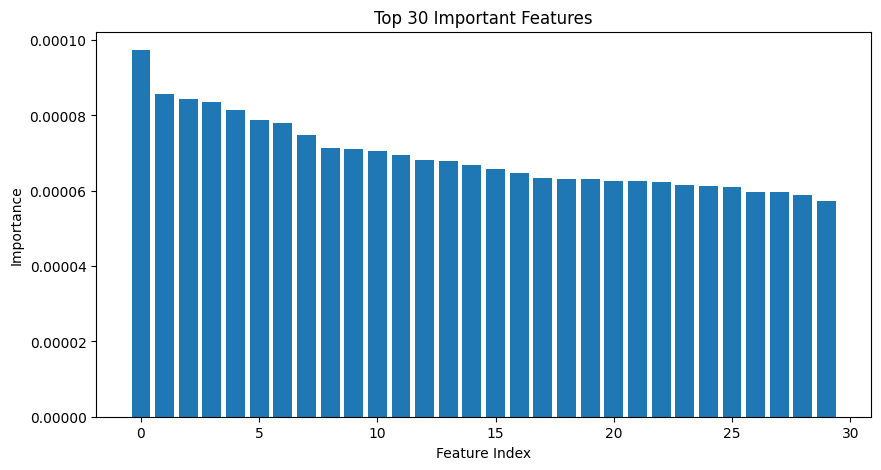

In [ ]:
import numpy as np
import joblib
import gc

X_train = np.load("train_features_axial_monai.npy", mmap_mode='r')  # read without loading all
y_train = np.load("train_labels_axial_monai.npy")
X_val = np.load("val_features_axial_monai.npy")

n_chunks = 10
chunk_size = X_train.shape[0] // n_chunks

feature_importances = np.zeros(X_train.shape[1])

for i in range(n_chunks):
    print(f"Processing chunk {i+1}/{n_chunks}")
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < n_chunks - 1 else X_train.shape[0]
    
    X_chunk = X_train[start:end]
    y_chunk = y_train[start:end]

    rf = RandomForestClassifier(n_estimators=25, random_state=42+i, n_jobs=-1)
    rf.fit(X_chunk, y_chunk)
    feature_importances += rf.feature_importances_
    del rf
    gc.collect()

# Average importances over chunks
feature_importances /= n_chunks

# Top features
top_indices = np.argsort(feature_importances)[::-1][:30]
np.save("rf_top30_indices.npy", top_indices)
X_train_reduced = X_train[:, top_indices]
X_val_reduced = X_val[:, top_indices]  # Do the same for test/val sets

# Save reduced datasets
np.save("X_train_reduced_monai.npy", X_train_reduced)
np.save("X_val_reduced_monai.npy", X_val_reduced)

# Save selected feature indices for future use
joblib.dump(top_indices, "selected_rf_indices_monai.pkl")
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_val[:, top_indices]  # Do the same for test/val sets
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_indices)), feature_importances[top_indices])
plt.title("Top 30 Important Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [6]:
x = np.load("X_train_reduced_monai.npy")
x2 = np.load("X_val_reduced_monai.npy")

print(x.shape)
print(x2.shape)

(169650, 30)
(16830, 30)


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


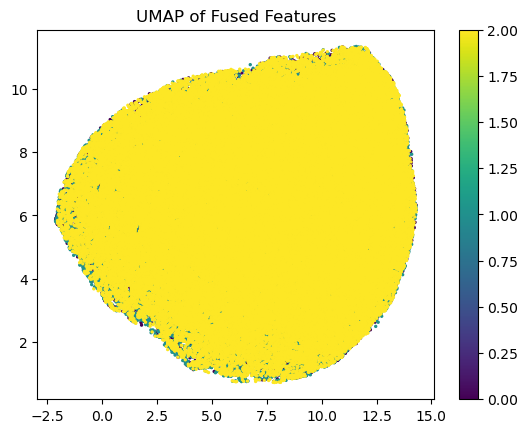

In [22]:
# for visualisation
import umap.umap_ as umap

X_train_reduced = np.load("X_train_reduced_monai.npy")
y_train = np.load("train_labels_axial_monai.npy")
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_train_reduced)

# Visualize 2D UMAP
import matplotlib.pyplot as plt
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

In [14]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 35150, 1: 51590, 2: 82910}


In [15]:
# Undersampled balanced
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_train_reduced, y_train)

# Then re-run UMAP
X_umap_bal = reducer.fit_transform(X_balanced)

In [16]:
# Supervised UMAP
reducer = umap.UMAP(n_components=3, random_state=42, target_metric='categorical')
X_umap_supervised = reducer.fit_transform(X_balanced, y_balanced)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


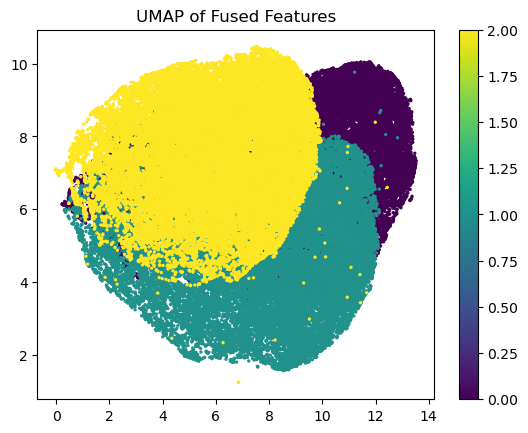

In [21]:
# Visualize 2D UMAP
import matplotlib.pyplot as plt
plt.scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], c=y_balanced, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

In [ ]:
# Load the .npy files
import pandas as pd
features = np.load("X_train_reduced_monai.npy")       
labels = np.load("train_labels_axial_monai.npy")           

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns

feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("train_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: train_axial_features_and_labels_only_monai.csv")


 Saved: train_axial_features_and_labels_only_monai.csv


same process for validation set

In [ ]:
# Load the .npy files
features = np.load("X_val_reduced_monai.npy")       # Shape: (84755, 256)
labels = np.load("val_labels_axial_monai.npy")           # Shape: (84755,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("val_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: val_axial_features_and_labels_only_monai.csv")


 Saved: val_axial_features_and_labels_only_monai.csv


In [65]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 51)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/1/2008,...,1.0,1.0,1.0,1.0,1.0,4150.0,127.0,5/5/2008,NaN,00:00.0
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,...,1.0,1.0,1.0,1.0,2.0,2370.0,127.0,9/18/2007,NaN,00:00.0
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/2/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,...,1.0,1.0,1.0,2.0,1.0,2110.0,127.0,8/15/2007,NaN,00:00.0


In [66]:
import pandas as pd
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
# Remove label 
df_cleaned = df.drop(columns=["Group", "Downloaded", "Modality", "Type", "Format"])

# Keep Image ID separately for future mapping
image_ids = df_cleaned["Image Data ID"].values

# Drop ID from the text encoding input
text_only = df_cleaned.drop(columns=["Image Data ID"])

# Convert each row to string and generate sentence embeddings
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()
texts = [t.lower().strip() for t in texts]

# Tokenize all text using CLIP
text_tokens = clip.tokenize(texts, truncate=True).to(device)

# Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()  # shape: (n_samples, 512)
# Save with Image IDs
import numpy as np
np.save("text_embeddings_cleaned.npy", text_embeddings)
np.save("text_image_ids.npy", image_ids)


In [76]:
print("Total samples in df_cleaned:", df_cleaned.shape[0])
print("Unique Image IDs in df_cleaned:", df_cleaned["Image Data ID"].nunique())

Total samples in df_cleaned: 2294
Unique Image IDs in df_cleaned: 2294


In [67]:
import numpy as np
import pandas as pd

# Load the cleaned text embeddings and associated image IDs
text_embeddings = np.load("text_embeddings_cleaned.npy")           # shape: (2294, 384)
text_image_ids = np.load("text_image_ids.npy", allow_pickle=True)  # shape: (2294,)

# Convert to DataFrame and add IDs as the first column
df = pd.DataFrame(text_embeddings)
df.insert(0, "Image_ID", text_image_ids)

# Save to CSV
df.to_csv("text_embeddings_cleaned_with_ids_monai.csv", index=False)

print(" Saved: text_embeddings_cleaned_with_ids_monai.csv")
print(" Shape:", df.shape)


 Saved: text_embeddings_cleaned_with_ids_monai.csv
 Shape: (2294, 513)


In [97]:
image_features = np.load("X_train_reduced_monai.npy")  
print(image_features.shape)

(169650, 30)


In [96]:
image_features = np.load("X_val_reduced_monai.npy")  
print(image_features.shape)

(16830, 30)


In [98]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_train_reduced_monai.npy")      
image_labels = np.load("train_labels_axial_monai.npy")     
image_paths = np.load("train_image_paths_axial.npy")      

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean_monai.npy", fused_features)
np.save("train_fused_labels_clean_monai.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 169650/169650 [00:00<00:00, 445317.90it/s]


 Matched samples: 169650
 Final train fused shape: (169650, 542)
 Labels shape: (169650,)


fusion for the validation set is done below

In [107]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_val_reduced_monai.npy")   # (16830, 30)
image_labels = np.load("val_labels_axial_monai.npy")     
image_paths = np.load("val_image_paths_axial_monai.npy")       

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

default_text_feat = np.zeros(384)

for img_feat, label, path in tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths)):
    img_id = os.path.basename(path).split('_')[0]
    
    # Use default if text not available
    text_feat = text_lookup.get(img_id, default_text_feat)
    
    fused = np.concatenate([img_feat, text_feat])
    fused_features.append(fused)
    fused_labels.append(label)

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean_monai.npy", fused_features)
np.save("val_fused_labels_clean_monai.npy", fused_labels)

print(" Final val fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 16830/16830 [00:00<00:00, 364663.68it/s]

 Matched samples: 0
 Final val fused shape: (16830, 542)
 Labels shape: (16830,)


Check the textual data variation


Training Set text label distribution:
  Class 0: 469 samples
  Class 1: 753 samples
  Class 2: 319 samples


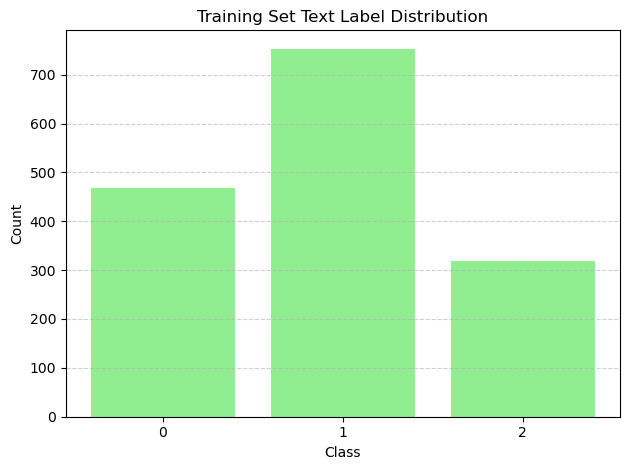


Validation Set text label distribution:
  Class 0: 47 samples
  Class 1: 72 samples
  Class 2: 34 samples


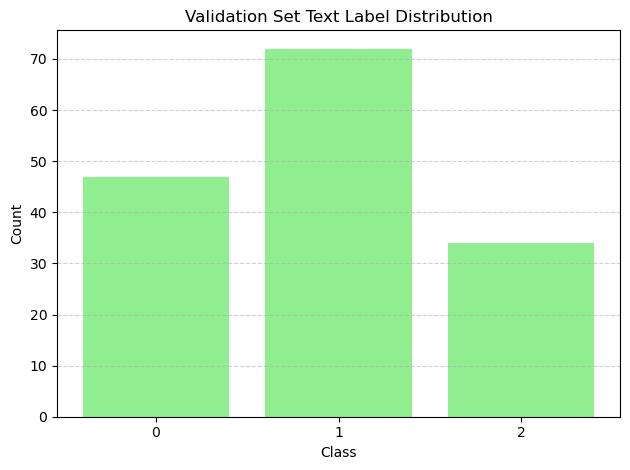

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load your main metadata DataFrame
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv") 

# Optional: convert label names to numeric codes if not already
# Example: {'CN': 0, 'MCI': 1, 'AD': 2}
label_map = {'CN': 0, 'MCI': 1, 'AD': 2}
df["Label"] = df["Group"].map(label_map)  # replace "Group" with actual label column

# Keep the image IDs
image_ids = df["Image Data ID"].values

# Load train/val image path files
train_paths = np.load("train_image_paths_axial.npy")  # contains full paths like '.../I12345_AD_axial_55.png'
val_paths = np.load("val_image_paths_axial_monai.npy")

# Extract image IDs from paths
def extract_ids(paths):
    return set([os.path.basename(p).split('_')[0] for p in paths])

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)

# Split DataFrame
df_train = df[df["Image Data ID"].isin(train_ids)]
df_val = df[df["Image Data ID"].isin(val_ids)]

# Show counts
def analyze_subset(df_subset, name):
    labels = df_subset["Label"].dropna().astype(int)
    counter = Counter(labels)
    print(f"\n{name} text label distribution:")
    for label, count in sorted(counter.items()):
        print(f"  Class {label}: {count} samples")
    
    # Plot
    plt.bar(counter.keys(), counter.values(), color='lightgreen')
    plt.title(f"{name} Text Label Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(sorted(counter.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Analyze
analyze_subset(df_train, "Training Set")
analyze_subset(df_val, "Validation Set")

In [61]:
id_to_label = {}

# Build a lookup from image ID to label
for label, path in zip(image_labels, image_paths):
    img_id = os.path.basename(path).split('_')[0]
    id_to_label[img_id] = label

# Now count the labels in your text_ids
text_labels = [id_to_label[id_] for id_ in text_ids if id_ in id_to_label]
unique, counts = np.unique(text_labels, return_counts=True)
print("Text embedding label distribution:", dict(zip(unique, counts)))

Text embedding label distribution: {0: 38, 1: 115}


In [56]:
print(f"Total images: {len(image_paths)}")
print(f"Unique text IDs: {len(text_ids)}")

# Check overlap
matched = 0
for path in image_paths:
    img_id = os.path.basename(path).split('_')[0]
    if img_id in text_lookup:
        matched += 1

print(f"Image IDs matched with text: {matched}")

Total images: 8415
Unique text IDs: 2294
Image IDs matched with text: 8415


In [57]:
fused_labels = np.load("val_fused_labels_clean_monai.npy")
unique, counts = np.unique(fused_labels, return_counts=True)
print("Label distribution in fused val set:", dict(zip(unique, counts)))

Label distribution in fused val set: {0: 3740, 1: 4675}


In [108]:
from tqdm import tqdm
import numpy as np
import os

# Load image feature data
image_features = np.load("X_val_reduced_monai.npy")       # (16830, 256)
image_labels = np.load("val_labels_axial_monai.npy")      # (16830,)
image_paths = np.load("val_image_paths_axial_monai.npy")        # (16830,)

# Load textual embeddings and ID mapping
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Build text embedding lookup
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}
default_text_feat = np.zeros(384)  # fallback if no text embedding

# Fuse image + text features for all validation samples
fused_features = []
fused_labels = []

for img_feat, label, path in tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths)):
    img_id = os.path.basename(path).split('_')[0]
    text_feat = text_lookup.get(img_id, default_text_feat)
    fused = np.concatenate([img_feat, text_feat])
    fused_features.append(fused)
    fused_labels.append(label)

# Save fused features
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_full_monai.npy", fused_features)
np.save("val_fused_labels_full_monai.npy", fused_labels)

# Print confirmation
unique, counts = np.unique(fused_labels, return_counts=True)
print("✅ Done! Label distribution in full val set:", dict(zip(unique, counts)))

100%|██████████| 16830/16830 [00:00<00:00, 349113.92it/s]

✅ Done! Label distribution in full val set: {0: 3740, 1: 5170, 2: 7920}


In [109]:
unique, counts = np.unique(image_labels, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(fused_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3740, 1: 5170, 2: 7920}
{0: 3740, 1: 5170, 2: 7920}


In [110]:
import numpy as np
import pandas as pd

# Load
X = np.load("train_fused_features_clean_monai.npy")
y = np.load("train_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels_monai.csv")


 Saved: train_fused_embeddings_with_labels_monai.csv


In [111]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 35150, 1: 51590, 2: 82910}


savinf into csv the validation fused sets

In [112]:
import numpy as np
import pandas as pd

# Load
X = np.load("val_fused_features_clean_monai.npy")
y = np.load("val_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels_monai.csv")


 Saved: val_fused_embeddings_with_labels_monai.csv


In [113]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3740, 1: 5170, 2: 7920}


saving image and textual data separately for training dataset

In [114]:
import numpy as np

# Load fused embeddings
fused = np.load("train_fused_features_clean_monai.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("train_image_features_only_monai.npy", image_features)
np.save("train_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  train_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  train_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  train_image_features_only_monai.npy (shape: (169650, 256) )
  train_text_features_only_monai.npy  (shape: (169650, 286) )


saving image and textual data separately for validation dataset

In [115]:
import numpy as np

# Load fused embeddings
fused = np.load("val_fused_features_clean_monai.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("val_image_features_only_monai.npy", image_features)
np.save("val_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  val_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  val_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  val_image_features_only_monai.npy (shape: (16830, 256) )
  val_text_features_only_monai.npy  (shape: (16830, 286) )


In [9]:
import torch.nn as nn

class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),   # input size must match your fused feature size (e.g., 1024 if CLIP image+text)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)       # 3 output classes (AD, CN, MCI)
        )
    def forward(self, x):
        return self.net(x)


Epoch 1/10, Train Loss: 0.6085, Val Loss: 1.3393
Epoch 2/10, Train Loss: 0.1359, Val Loss: 2.0479
Epoch 3/10, Train Loss: 0.0486, Val Loss: 2.3551
Epoch 4/10, Train Loss: 0.0290, Val Loss: 2.7909
Epoch 5/10, Train Loss: 0.0202, Val Loss: 3.1643
Epoch 6/10, Train Loss: 0.0159, Val Loss: 3.1534
⏹️ Early stopping at epoch 6
📊 Training Accuracy: 0.9998
✅ Validation Accuracy: 0.5889
Classification Report:
               precision    recall  f1-score   support

          AD       0.52      0.45      0.48      3740
          CN       0.57      0.34      0.42      5170
         MCI       0.61      0.82      0.70      7920

    accuracy                           0.59     16830
   macro avg       0.57      0.54      0.54     16830
weighted avg       0.58      0.59      0.57     16830



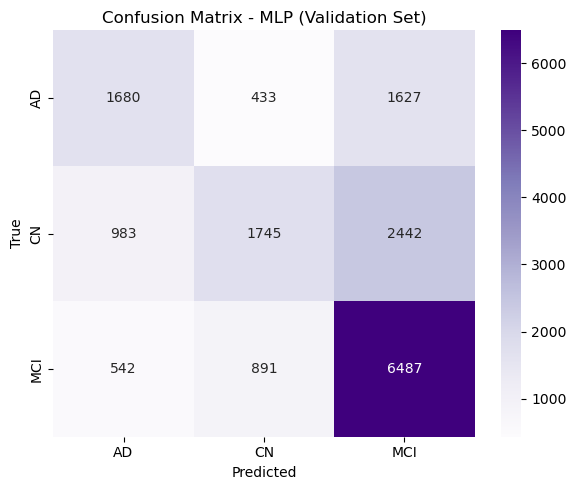

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_fused_features_clean_monai.npy")
y_train = np.load("train_fused_labels_clean_monai.npy")
X_val = np.load("val_fused_features_clean_monai.npy")
y_val = np.load("val_fused_labels_clean_monai.npy")

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


input_dim = X_train.shape[1]
model = MLPWithDropout(input_dim).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


train_losses = []
val_losses = []
best_val_loss = float("inf")
early_stop_epoch = -1
patience = 5
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        early_stop_epoch = epoch
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

import gc
gc.collect()
torch.cuda.empty_cache()

# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

# Training Metrics
train_acc = accuracy_score(y_train_true, y_train_preds)
print(f"📊 Training Accuracy: {train_acc:.4f}")

# 🔹 Evaluate on Validation Set
model.eval()
y_val_preds = []
y_val_true = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_val_preds.extend(preds.cpu().numpy())
        y_val_true.extend(yb.numpy())

# Metrics
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD", "CN", "MCI"]))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

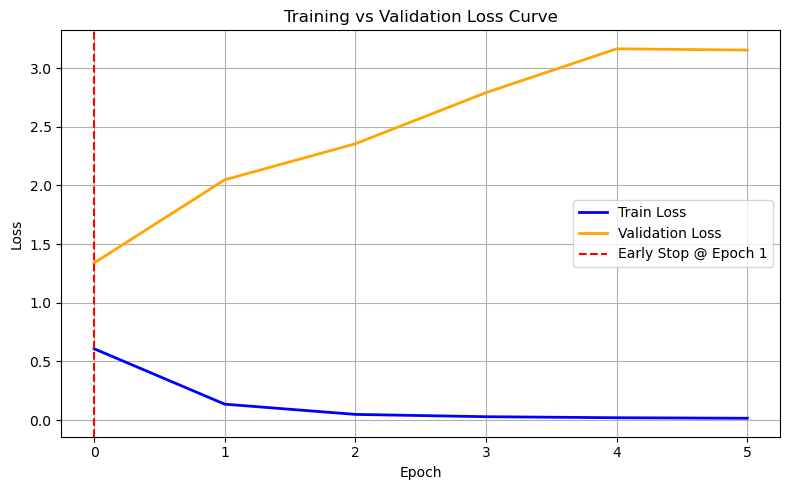

In [11]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/100, Train Loss: 0.8955, Val Loss: 1.0298
Epoch 2/100, Train Loss: 0.6135, Val Loss: 1.0555
Epoch 3/100, Train Loss: 0.4232, Val Loss: 1.0927
Epoch 4/100, Train Loss: 0.2948, Val Loss: 1.1811
Epoch 5/100, Train Loss: 0.2080, Val Loss: 1.2382
Epoch 6/100, Train Loss: 0.1487, Val Loss: 1.3387
⏹ Early stopping triggered at epoch 6

✅ Validation Accuracy: 0.5251
Classification Report:
               precision    recall  f1-score   support

          CN       0.46      0.47      0.47      3740
         MCI       0.46      0.36      0.41      5170
          AD       0.58      0.66      0.62      7920

    accuracy                           0.53     16830
   macro avg       0.50      0.50      0.50     16830
weighted avg       0.52      0.53      0.52     16830



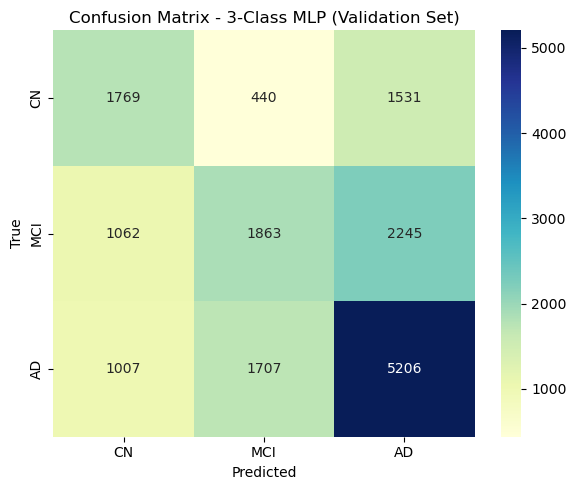

In [120]:
import numpy as np
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# ---------- Load data ----------
X_train = np.load("train_fused_features_clean_monai.npy")
y_train = np.load("train_fused_labels_clean_monai.npy")
X_val = np.load("val_fused_features_clean_monai.npy")
y_val = np.load("val_fused_labels_clean_monai.npy")

# ✅ Don't convert to binary
# y_train = np.where(y_train == 2, 1, 0)

# ---------- Preprocess ----------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Oversample minority classes
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ---------- Model ----------
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=3):  # 3 classes
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Training setup
input_dim = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPWithDropout(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# ---------- Training ----------
num_epochs = 100
patience = 5
train_losses = []
val_losses = []
best_val_loss = float("inf")
early_stop_epoch = -1
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)  # shape: [batch_size, 3]
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0
    y_val_preds = []
    y_val_true = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        early_stop_epoch = epoch
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break

# ---------- Evaluation ----------
model.load_state_dict(best_model_state)

# On validation set
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["CN", "MCI", "AD"]))

cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["CN", "MCI", "AD"], yticklabels=["CN", "MCI", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - 3-Class MLP (Validation Set)")
plt.tight_layout()
plt.show()

Using device: cpu
Epoch 1/100, Train Loss: 0.6657, Val Loss: 0.6716
Epoch 2/100, Train Loss: 0.5972, Val Loss: 0.6721
Epoch 3/100, Train Loss: 0.5097, Val Loss: 0.6840
Epoch 4/100, Train Loss: 0.4262, Val Loss: 0.7187
Epoch 5/100, Train Loss: 0.3492, Val Loss: 0.7445
Epoch 6/100, Train Loss: 0.2795, Val Loss: 0.7962
⏹ Early stopping triggered at epoch 6
 Training Accuracy: 0.9753
 Validation Accuracy: 0.6764
Classification Report:
               precision    recall  f1-score   support

     Not MCI       0.71      0.65      0.68      8910
         MCI       0.64      0.70      0.67      7920

    accuracy                           0.68     16830
   macro avg       0.68      0.68      0.68     16830
weighted avg       0.68      0.68      0.68     16830



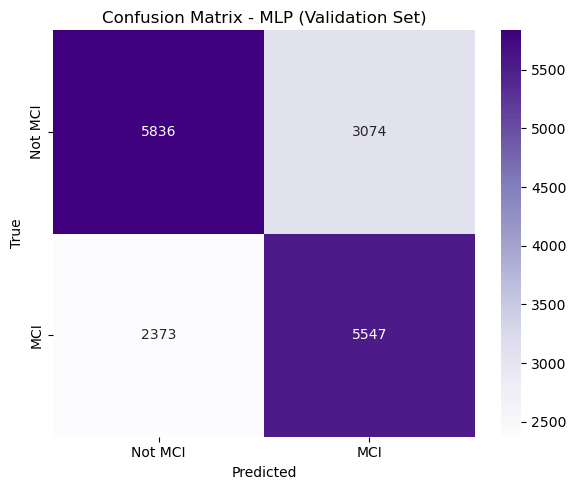

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_fused_features_clean_monai.npy")
y_train = np.load("train_fused_labels_clean_monai.npy")
X_val = np.load("val_fused_features_clean_monai.npy")
y_val = np.load("val_fused_labels_clean_monai.npy")

y_train = np.where(y_train == 2, 1, 0)
y_val = np.where(y_val == 2, 1, 0)

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # False for no randomess in mini-batches
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)



input_dim = X_train.shape[1]  # or manually set to 256 for image-only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = MLPWithDropout(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Early stop[ping variables
num_epochs = 100
patience = 5  # how many epochs to wait before early stopping

train_losses = []
val_losses = []

best_val_loss = float("inf")
early_stop_epoch = -1
epochs_no_improve = 0
best_model_state = None



for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------- Validation and Early Stopping ----------------
    model.eval()
    val_loss = 0.0
    y_val_preds = []
    y_val_true = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.unsqueeze(1).float())
            val_loss += loss.item()
            preds = (torch.sigmoid(out).squeeze() > 0.5).int()
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        early_stop_epoch = epoch
        best_model_state = model.state_dict()

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop_epoch = epoch  # ⏹️ Where stopping actually happens
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break
# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = (torch.sigmoid(out).squeeze() > 0.5).int()  
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

    # Training Metrics
    train_acc = accuracy_score(y_train_true, y_train_preds)
    print(f" Training Accuracy: {train_acc:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# Final evaluation on validation set
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f" Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["Not MCI", "MCI"]))

cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not MCI", "MCI"], yticklabels=["Not MCI", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

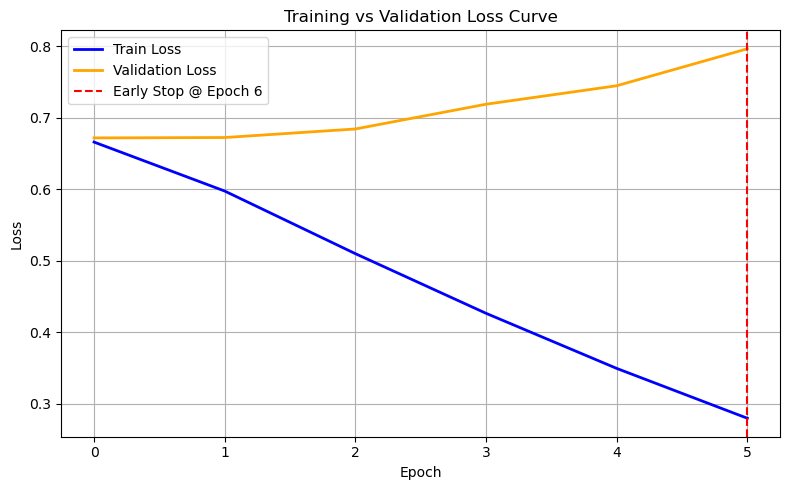

In [7]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

# Mark early stopping epoch
if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()